# Lab - Dogs vs Cats

Syftet med den här labben är att använda deep learning för computer vision för att lära sig att klassificera
olika objekt.

I den här labben kommer du få jobba med bildbehandling, filhantering, bygga upp egna tränings, validerings
och testdataset från en mängd av bilder. Vidare får du jobba med begränsade datamängder för att efterlikna
verkligheten när dataanskaffning är en oerhört dyr process. Efter databehandlingen och databearbetningen
kommer du få pröva olika slags convolutional neural networks tränade från scratch och slutligen använda
dig av transfer learning för att återanvända nätverk skapade av toppforskare inom computer vision.

## Uppgifter
Dokumentera i markdown i Jupyter notebook eller i separat markdownfil om du använder Pythonskript.

### 0. EDA och filhantering (*)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import random
import os
import shutil

#### c) Skapa folderstrukturen med Python

In [50]:
#for size in ["small", "tiny"]:
#    os.mkdir(f"experiment_{size}_data")
#    for dataset in ["test", "train", "val"]:
#        os.mkdir(f"experiment_{size}_data/{dataset}")

#os.rename("Pictures_of_dogs_and_cats", "original_data")

#### a) Börja med att ladda ned datasetet Dogs vs Cats från Kaggle. Extrahera den och lägg den i din labfolder, glöm inte att lägga till den till .gitignore.

#### b) Läs in 10 bilder slumpmässigt, plotta dem och extrahera deras labels och skriv ut i titeln.

In [2]:
def plot_random_sample(number_of_samples:int):
    
    # Initialise variables
    labels = [random.choice(["cat", "dog"]) for i in range(number_of_samples)]
    numbers = random.sample(range(12500), number_of_samples)
    images = []
    number_of_rows = None

    # Specifies number of rows to plot
    if number_of_samples % 5 == 0:
        number_of_rows = int(number_of_samples/5)
    else:
        number_of_rows = int((number_of_samples/5)+1)

    # Read the images and save the labels
    for label, number in zip(labels, numbers):
        if label == "cat":
            images.append(plt.imread(f"original_data/train/cat.{number}.jpg"))
        else:
            images.append(plt.imread(f"original_data/train/dog.{number}.jpg"))
    
    # Create plots
    fig, axes = plt.subplots(number_of_rows, 5, figsize=(20, 20))

    for i, ax, label in zip(range(number_of_samples), axes.flatten(), labels):
        ax.imshow(images[i]) 
        ax.axis("off")
        if label == "cat":
            ax.set(title="Cat: 0")
        else:
            ax.set(title="Dog: 1")

    fig.subplots_adjust(wspace=0.1, hspace=0.1, bottom=0.01, top=0.4)

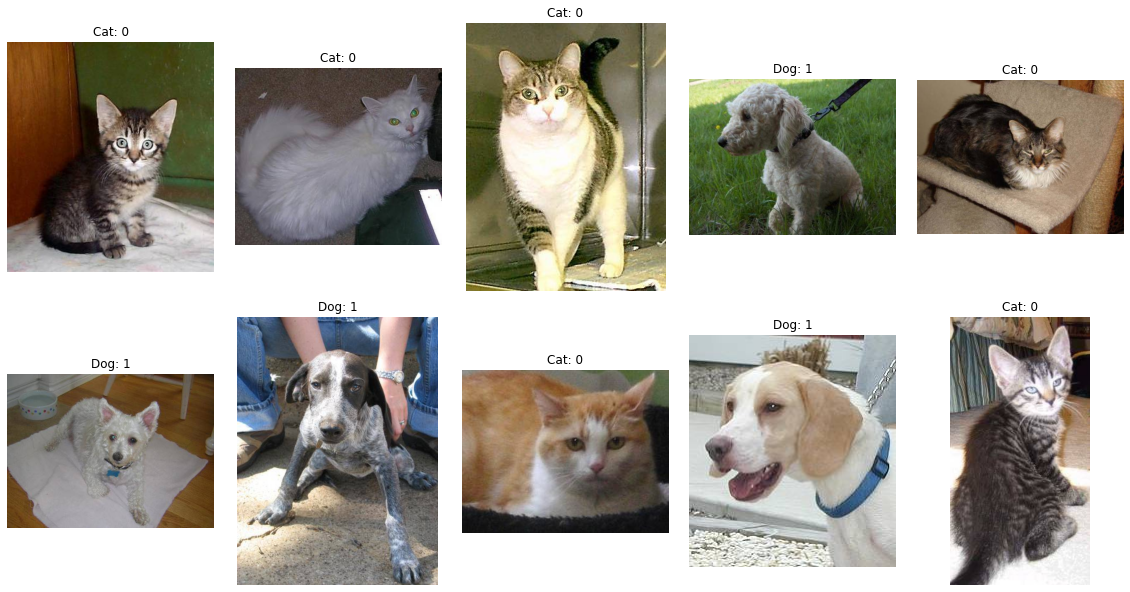

In [51]:
plot_random_sample(10)

#### d) Nu ska du göra train|val|test split med följande splits:

experiment_small
- train - 1600 (800 dogs, 800 cats)
- val - 400 (200 dogs, 200 cats)
- test - 500 (250 dogs, 250 cats)

experiment_tiny (BONUS)
- train - 160 (80 dogs, 80 cats)
- val - 40 (20 dogs, 20 cats)
- test - 50 (25 dogs, 25 cats)

Det är inte så farligt om det inte blir exakt balanserade dataset.

Det är viktigt att du samplar slumpmässigt utan replacement från originaldatasetet under respektive
experiment. Spara datan i deras respektive mappar. (**)

In [12]:
img_names = pd.DataFrame({"file_name" : os.listdir("original_data/train")})
img_names["cat"] = img_names["file_name"].str.contains("cat") 

cats = img_names[img_names["cat"] == True]
dogs = img_names[img_names["cat"] == False]
len(cats), len(dogs)

(12500, 12500)

In [3]:
def train_val_test_split(data1:pd.Series, data2:pd.Series, train_size:int, val_size:int, test_size:int):

    train_size = int(train_size/2)
    val_size = int(val_size/2)
    test_size = int(test_size/2)

    full_sample_size = train_size + val_size + test_size
    data1_full_sample = random.sample(list(data1), full_sample_size)
    data2_full_sample = random.sample(list(data2), full_sample_size)

    data1_train = random.sample(data1_full_sample, train_size)
    data2_train = random.sample(data2_full_sample, train_size)
    train = data1_train + data2_train

    data1_val = random.sample(list(set(data1_full_sample) - set(data1_train)), val_size) #Reference: https://stackoverflow.com/questions/41125909/python-find-elements-in-one-list-that-are-not-in-the-other
    data2_val = random.sample(list(set(data2_full_sample) - set(data2_train)), val_size)
    val = data1_val + data2_val

    data1_test = random.sample(list(set(data1_full_sample) - set(data1_train) - set(data1_val)), test_size)
    data2_test = random.sample(list(set(data2_full_sample) - set(data2_train) - set(data2_val)), test_size)
    test = data1_test + data2_test

    return train, val, test

In [71]:
#train_small, val_small, test_small = train_val_test_split(cats["file_name"], dogs["file_name"], 1600, 400, 500)
#train_tiny, val_tiny, test_tiny = train_val_test_split(cats["file_name"], dogs["file_name"], 160, 40, 50)

In [69]:
#for data, folder in zip([train_tiny, val_tiny, test_tiny], ["train", "val", "test"]):
    
#    for file_name in data:
#        source_path = f"original_data/train/{file_name}"
#        target_path = f"experiment_tiny_data/{folder}/{file_name}"
#        shutil.copyfile(source_path, target_path)

In [70]:
#for data, folder in zip([train_small, val_small, test_small], ["train", "val", "test"]):

#    for file_name in data:
#        source_path = f"original_data/train/{file_name}"
#        target_path = f"experiment_small_data/{folder}/{file_name}"
#        shutil.copyfile(source_path, target_path)

### e) Läs in dataseten från experiment_small, experiment_tiny och plocka ut labelsvektorer, som ska vara one-hot encoded med 0 och 1.

plotta några bilder med deras respektive labels och kontrollera att det är korrekt.

In [4]:
def read_images(folder_path):

    data = []
    labels = []
    img_names = os.listdir(folder_path)

    for file in img_names:
        data.append(plt.imread(f"{folder_path}/{file}"))
    data = np.asarray(data, dtype=object)

    for img_name in img_names:
        if "cat" in img_name:
            labels.append(0)
        else:
            labels.append(1)
    labels = np.asarray(labels, dtype=object)

    np.random.seed(42)
    np.random.shuffle(data)
    np.random.seed(42)
    np.random.shuffle(labels)

    return data, labels

In [5]:
X_train_small, y_train_small = read_images("experiment_small_data/train")
X_val_small, y_val_small  = read_images("experiment_small_data/val")
X_test_small, y_test_small = read_images("experiment_small_data/test")

X_train_tiny, y_train_tiny = read_images("experiment_tiny_data/train")
X_val_tiny, y_val_tiny = read_images("experiment_tiny_data/val")
X_test_tiny, y_test_tiny = read_images("experiment_tiny_data/test")

In [6]:
print(X_train_small.shape, X_val_small.shape, X_test_small.shape, X_train_tiny.shape, X_val_tiny.shape, X_test_tiny.shape)
print(y_train_small.shape, y_val_small.shape, y_test_small.shape, y_train_tiny.shape, y_val_tiny.shape, y_test_tiny.shape)

print(X_train_small[0].shape)
print(y_train_small[0])

(1600,) (400,) (500,) (160,) (40,) (50,)
(1600,) (400,) (500,) (160,) (40,) (50,)
(499, 362, 3)
1


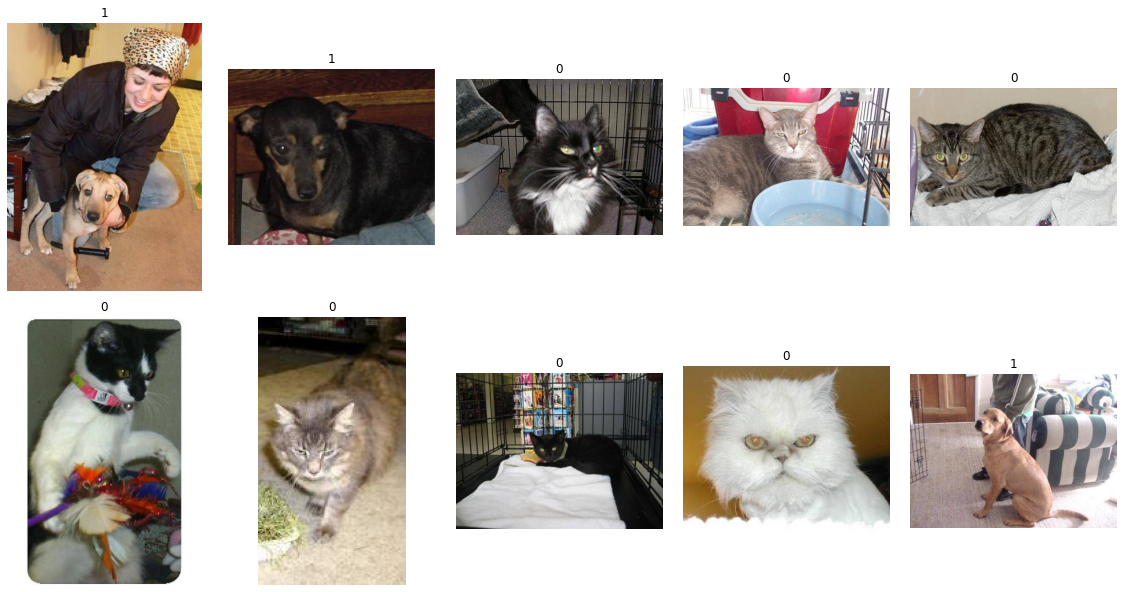

In [7]:
fig, axes = plt.subplots(2, 5, figsize=(20, 20))

for i, ax, label in zip(range(25), axes.flatten(), y_train_small):
    ax.imshow(X_train_small[i]) 
    ax.axis("off")
    ax.set(title=label)

fig.subplots_adjust(wspace=0.1, hspace=0.1, bottom=0.01, top=0.4)

skapa lämplig plot för att kontrollera att dataseten är balanserade

In [8]:
data = [y_train_small, y_val_small, y_test_small, y_train_tiny, y_val_tiny, y_test_tiny]
dataset_name = ["Small Data: train", "Small Data: val", "Small Data: test", "Tiny Data: train", "Tiny Data: val", "Tiny Data: test"]

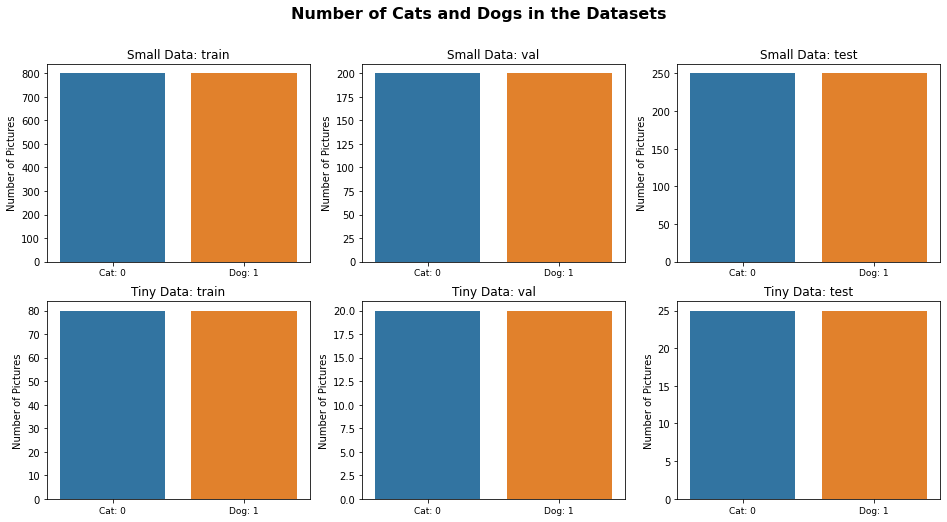

In [9]:
fig, axes = plt.subplots(2, 3, figsize=(16, 8))

for ax, dataset, name in zip(axes.flatten(), data, dataset_name):
    sns.countplot(x=dataset, ax=ax)
    ax.set(title=name, ylabel="Number of Pictures")
    ax.set_xticklabels(["Cat: 0", "Dog: 1"], size=9)

fig.suptitle("Number of Cats and Dogs in the Datasets", size=16, fontweight="bold");

skapa lämplig plot för att kontrollera att dataseten är slumpade (dvs inte ex [0, 0, ... 0, 1, 1, ..., 1]).

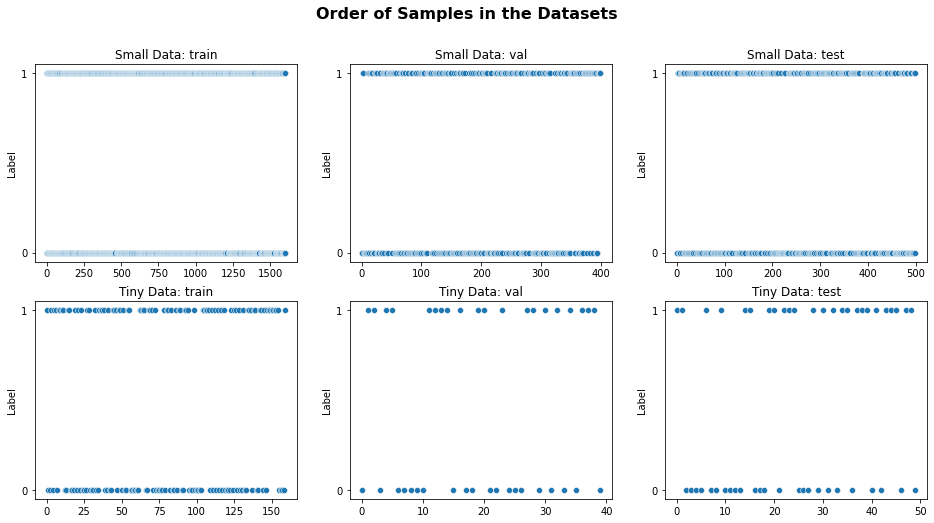

In [10]:
fig, axes = plt.subplots(2, 3, figsize=(16, 8))

for ax, dataset, name in zip(axes.flatten(), data, dataset_name):
    sns.scatterplot(data=dataset, ax=ax)
    ax.set(title=name, ylabel="Label")
    ax.locator_params(axis='y', nbins=2)
    ax.set_yticks([0, 1])

fig.suptitle("Order of Samples in the Datasets", size=16, fontweight="bold");

## 1. Bildbehandling (*)

Uppgifterna nedan ska upprepas för respektive experimentdataset om du också väljer att arbeta med
tinydatasetet.

### a) Skapa en plot för att visualisera bildstorlekarna i träningsdatan. Använd seaborns jointplot.

In [21]:
height_small = [X_train_small[i].shape[0] for i in range(len(X_train_small))]
width_small = [X_train_small[i].shape[1] for i in range(len(X_train_small))]

height_tiny = [X_train_tiny[i].shape[0] for i in range(len(X_train_tiny))]
width_tiny = [X_train_tiny[i].shape[1] for i in range(len(X_train_tiny))]

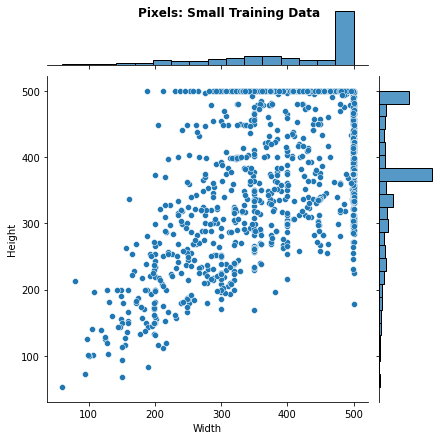

In [30]:
fig = sns.jointplot(x=width_small, y=height_small)
fig.ax_joint.set(xlabel="Width", ylabel="Height")
fig.fig.suptitle("Pixels: Small Training Data", size=12, fontweight="bold");

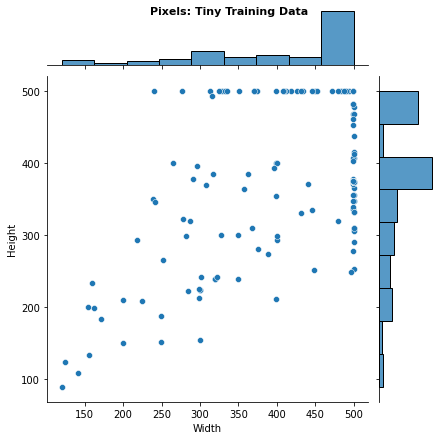

In [31]:
fig = sns.jointplot(x=width_tiny, y=height_tiny)
fig.ax_joint.set(xlabel="Width", ylabel="Height")
fig.fig.suptitle("Pixels: Tiny Training Data", size=11, fontweight="bold");